# Liear property of Transformers positional encodings

#This notebook demonstrates the property of transformers positional encodings to be represented by linear transformaitons of each other.

Paper that introduces the positional encodings: Attention is all you need [https://arxiv.org/abs/1706.03762]

In the paper authors encode index of the word $\large t$ into feature vector $\large \vec{p} \in \mathbb{R}^{d}$:

$\large \vec{p}(t)^{(i)} = f(t)^{(i)}$,

$d$ - is the length of the feature vector.

Authors say, they chose functions f(t) because for any fixed offset $\phi$, $f(t+\phi)$ can be represented as linear function of $f(t)$.

In this notebook we implement and visualize this property to get better understanding of how transformers can use the positional encoding internally.

## Positional enconding

First lets start with the positional encoding formulas described in the paper "Attention is all you need":



$$\large PE(pos,2i) = sin(pos/10000^{2i/d})$$

$$\large PE(pos,2i+1) = cos(pos/10000^{2i/d})$$


Below is an equavelnt formulas, which are easier to read:



$\large f(t)^{(i)} =     \begin{cases}
      sin(w_kt) & \text{if i = 2k}\\
      cos(w_kt) & \text{if i = 2k+1}\\
    \end{cases} $

where

$\large w_k = \frac{1}{10000^{2i/d}}, k\in \{1, ..., d/2\} $ are frequencies used for coding particular element of the feature vector.

Authors say, they chose this function because for any fixed offset $\phi$, $f(t+\phi)$ can be represented as linear function of $f(t)$.

That property can potentially allow the model to attend to different words via dot product and matrix multiplications that is extensively used in Transformers. 
***
Let's visualize the positional encodings. We will use 200 pe vectors with 256 features.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#first lets define embedding size and maximal_number of indexes
MAX_LEN = 200 #maximum length of the sequence
EMBEDDINGS_SIZE = 256 #d

In [5]:
#compute the position encodings according to formulas
pe = np.zeros((MAX_LEN, EMBEDDINGS_SIZE))
position = np.arange(0, MAX_LEN, dtype=np.float)
#use logexp trick for numeric stability  
w = np.exp(np.arange(0, EMBEDDINGS_SIZE, 2).astype(np.float) * (-np.log(10000.0) / EMBEDDINGS_SIZE))
 
position = position[:, np.newaxis]
pe[:, 0::2] = np.sin(position * w[np.newaxis, :])
pe[:, 1::2] = np.cos(position * w[np.newaxis, :])

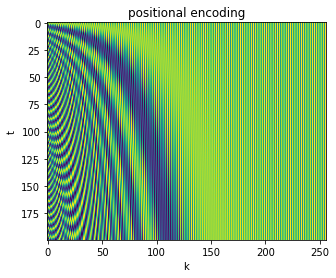

In [6]:
#visualize the encodings
plt.imshow(pe)
plt.xlabel('k')
plt.ylabel('t')
plt.title('positional encoding')
plt.show()

***

## 1-st approach

***
To demonstrate that the positional encodings can be represented by linear tranformations of each other we can startby showing that we can build 2x2 matrix $M(k,\phi)$, such that 

$\large M(k,\phi) \textbf{f}_t^{(i)} = \textbf{f}_{t+\phi}^{(i)}$,

where $\large \textbf{f}_t^{(i)} = \begin{bmatrix} sin(w_kt) \\   cos(w_kt) \end{bmatrix} $ 
is i-th element of encoding of $t$-th word index, and 
$\textbf{f}_{t+\phi}^{(i)} = \begin{bmatrix} sin(w_kt + \phi) \\   cos(w_kt + \phi) \end{bmatrix} $ 
is encoding of $t + \phi$ index.

One can show that the matrix M should have form of the following rotation matrix:

$M(k,\phi) = \begin{bmatrix} cos(w_k \phi) & sin(w_k \phi) \\ -sin(w_k \phi) & cos(w_k \phi) \end{bmatrix} $.


$M(k,\phi)$ depends on feature index $k$ and shift $\phi$ but doesn't depend on index $t$.


For more detail see https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

Let us apply appropriate matrices $M(k,\phi=100)$ in naive for loop for every element of pe to see what whill happen with positional encodings.

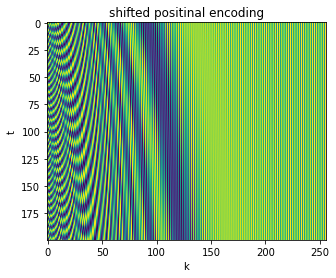

In [6]:
#Let us apply appropriate matrices M(k,phi=100) in naive for loop for every element of pe

def apply_shift_for(pe, w_k, shift):
    shifted_pe = np.zeros([MAX_LEN, EMBEDDINGS_SIZE])
    for t in range(MAX_LEN):
        f0 = pe[t]
        for k in range(EMBEDDINGS_SIZE // 2):
            freq_corr = shift * w[k]
            M = np.array(
                [
                    [np.cos(freq_corr), np.sin(freq_corr)],
                    [-np.sin(freq_corr), np.cos(freq_corr)]
                ]
            )
            res = np.matmul(M, np.array([[f0[2 * k]], [f0[2 * k + 1]]]))
            shifted_pe[t, k * 2] = res[0]
            shifted_pe[t, k * 2 + 1] = res[1]
    return shifted_pe, None

shifted_pe,_  = apply_shift_for(pe, w, 100)
plt.imshow(shifted_pe)
plt.title("shifted positinal encoding")
plt.xlabel('k')
plt.ylabel('t')
plt.show()

We see that the picture moved up according to used $\phi=100$. We also see that network can potentially learn to use encodings beyond the predefined interval of 200 indexes (bottom vectors were not presented in the original figure).  

Let us ensure that 100-th element of pe is now 0-th element of shifted_pe.

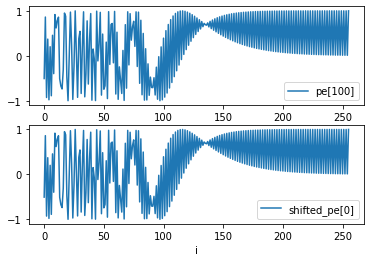

In [7]:
#
plt.subplot(2,1,1)
plt.plot(range(EMBEDDINGS_SIZE), pe[100])
plt.legend(["pe[100]"])
plt.subplot(2,1,2)
plt.xlabel('i')
plt.plot(range(EMBEDDINGS_SIZE), shifted_pe[0])
plt.legend(["shifted_pe[0]"])
plt.xlabel('i')
plt.show()

They look exactly the same and that is excatly what was expected.

***
## 2-nd approach
***
The above implementation recomputes $M(k,\phi)$ excessive number of times. Let us try to vectorize these computaions to get more intution of what is going inside the transformer if it uses this lienar property.

Solution can be found in [https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/]. We can obtain single $d \times d$ matrix $M(\phi)$ that warps the whole feature vector.
In this case $M(\phi)$ is a block matrix and has the following form:


$M(\phi) = \begin{bmatrix}
M(1,\phi) & \textbf{0} & \dots & \textbf{0}\\
\textbf{0} & M(2,\phi) & \dots & \textbf{0} \\
\textbf{0} & \textbf{0}  & \ddots & \textbf{0} \\
\textbf{0} & \textbf{0} & \dots & M(\frac{d}{2},\phi)
\end{bmatrix}$,

where $\textbf{0}$ is zero $2 \times 2$ matrix.
That means we got what we were looking for: a linear function that transforms feature vector to a shifted feature vector: 

$ M(k,\phi) \textbf{f}_t = \textbf{f}_{t+\phi}$

See https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/ for details.

Let us implement that in the code

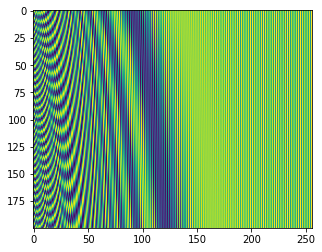

In [9]:
#we can compute the matrix M_phi and apply it to encodings with the following code
def apply_shift_mat(pe, w, shift):
    freq_corr = shift * w
    cos_f = np.cos(freq_corr)
    sin_f = np.sin(freq_corr)

    M = np.zeros([EMBEDDINGS_SIZE, EMBEDDINGS_SIZE])
    for k in range(0, EMBEDDINGS_SIZE, 2):
        M[k, k] = cos_f[k // 2]
        M[k, k + 1] = sin_f[k // 2]
        M[k+1, k] = -sin_f[k // 2]
        M[k + 1, k + 1] = cos_f[k // 2]

    shifted_pe = np.matmul(M, pe.transpose())

    return shifted_pe.transpose(), M

shifted_pe, M_phi  = apply_shift_mat(pe, w, 100)

plt.imshow(shifted_pe)

The figure is exactly the same and we can also visuzalize block matrix M_phi, which is very sparse

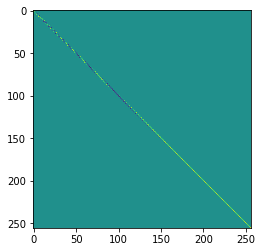

In [10]:
plt.imshow(M_phi)

$M_\phi$ can be potentially learned inside $Q,K,V$ which are the same dimensions $d \times d$ as $M(\phi)$.

***
## 3-rd approach
***
$M_\phi$  is very sparse and most of the computaions here is just waste of the resources. That may explain why authors suceed in using summation of positional encoding and word embedding instead of concatenating. In the latter case all zero element remain zeroes in a new larger matrix, why in the former they can be used to detect something usefull in the word embeddings.


Let's look onto vectorized form of the same computations. 

One can note that 1-st row of $M(k,\phi)$ is applyed to get even elements of the vector, and second row is applied to get odd elements.


Than we can have two matrices $M_1(\phi)$ and $M_2(\phi)$:

$M_1(\phi) = \begin{bmatrix} 
cos(\phi w_1) &  -sin(\phi w_k) \\ 
        \dots & \dots \\
cos(\phi w_{\frac{d}{2}}) &  -sin(\phi w_{\frac{d}{2}})
\end{bmatrix}$

$M_2(\phi) = \begin{bmatrix} 
sin(\phi w_1) &  cos(\phi w_k) \\ 
        \dots & \dots \\
sin(\phi w_{\frac{d}{2}}) &  cos(\phi w_{\frac{d}{2}})
\end{bmatrix}$

And we can transform the vector by applying this matrices to get odd and even elements of the transformed vector.

For those purposes we have to pack $f(t)$ from $1 \times d$ shape to $\hat{\textbf{f}}$ of shape $\frac{d}{2} \times 2$, where first and second columns are computed by sine and cosine respectively.

Than we can perform element-wise multiplication and column-wise addition to get new features:


$\hat{\textbf{f}}(t+\phi)_{2i} = M_1(\phi) \odot \hat{\textbf{f}}(t) $

$\hat{\textbf{f}}(t+\phi)_{2i+1} = M_2(\phi) \odot \hat{\textbf{f}}(t) $


$\textbf{f}(t+w)_{2i} = \hat{\textbf{f}}^{(1)}(t+\phi)_{2i} + \hat{\textbf{f}}^{(2)}(t+\phi)_{2i}$

$\textbf{f}(t+w)_{2i+1} = \hat{\textbf{f}}^{(1)}(t+\phi)_{2i+1} + \hat{\textbf{f}}^{(2)}(t+\phi)_{2i+1}$


where $\odot$ denotes element-wise multiplication.

Text(0.5, 1.0, 'shifted positinal encoding')

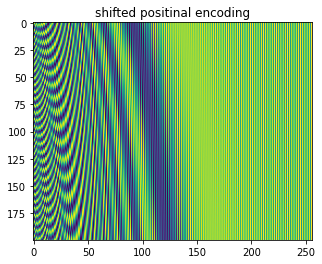

In [7]:
def apply_shift_vectorized(pe, w, shift):
    freq_corr = shift * w
    shifted_pe = np.zeros([MAX_LEN, EMBEDDINGS_SIZE])
    M1 = np.stack([np.cos(freq_corr), np.sin(freq_corr)])
    M2 = np.stack([-np.sin(freq_corr), np.cos(freq_corr)])
    for t in range(MAX_LEN):
        f0 = pe[t]
        f0_packed = np.stack([f0[0::2], f0[1::2]])
        new_f01 = M1 * f0_packed
        new_f02 = M2 * f0_packed

        new_f01 = np.sum(new_f01, axis=0)
        new_f02 = np.sum(new_f02, axis=0)
        shifted_pe[t, 0::2] = new_f01
        shifted_pe[t, 1::2] = new_f02

    return shifted_pe, (M1, M2)

shifted_pe, (M1,M2) = apply_shift_vectorized(pe, w, 100)
plt.imshow(shifted_pe)
plt.title("shifted positinal encoding")

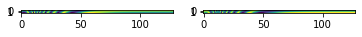

In [8]:
#We can visualize M1 and M2
plt.subplot(1,2,1)
plt.imshow(M1)
plt.subplot(1,2,2)
plt.imshow(M2)

***
## 4-th approach
***

What I don't like in the 3-rd approach's computations is packing and unpacking operations that cannot be repesented by a compact matrix.

The same transformation of $\textbf{f}_{t}$ into $\textbf{f}_{t+\phi}$ can be done in the form:

$\textbf{f}_{t+\phi} = \textbf{a} \odot \textbf{f}_{t}  + \textbf{b} \odot \bar {\textbf{f}}_{t}$,

where

$\textbf{a}=\begin{bmatrix} cos(w_0) \\ cos(w_0)\\ cos(w_1) \\ cos(w_1) \\ ... \\ cos(w_{d/2}) \end{bmatrix}$

$\textbf{b}=\begin{bmatrix} sin(w_0) \\ -sin(w_0) \\ sin(w_1) \\ -sin(w_1) \\ ... \\ sin(w_{d/2}) \end{bmatrix}$

and $\bar {\textbf{f}}_{t} $ is $\textbf{f}_{t}$ with swaped odd and even elements.

Text(0.5, 1.0, 'shifted positinal encoding')

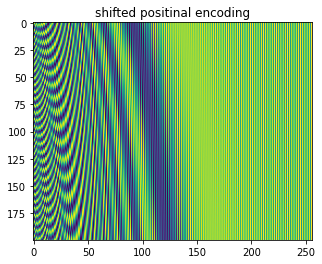

In [13]:

def apply_shift_vectorized2(pe, w, shift):
    freq_corr = shift * w
    shifted_pe = np.zeros([MAX_LEN, EMBEDDINGS_SIZE])
    M1_vec = np.zeros([EMBEDDINGS_SIZE])
    M2_vec = np.zeros([EMBEDDINGS_SIZE])
    M1_vec[0::2] = np.cos(freq_corr)
    M1_vec[1::2] = np.cos(freq_corr)

    M2_vec[1::2] = -np.sin(freq_corr)
    M2_vec[0::2] = np.sin(freq_corr)

    for t in range(MAX_LEN):
        f0 = pe[t]
        f0_sw = np.zeros(len(f0))
        f0_sw[::2] = f0[1::2]
        f0_sw[1::2] = f0[0::2]
        shifted_pe[t] = (f0*M1_vec) + (f0_sw*M2_vec)

    return shifted_pe, (M1_vec, M2_vec)

shifted_pe, (M1,M2) = apply_shift_vectorized2(pe, w, 100)
plt.imshow(shifted_pe)
plt.title("shifted positinal encoding")

This transformation needs two dot products, vectors summation and swap of even and odd numbers in feature vector. This is computationally much more efficient than 3-rd approach with the matrix $M_\phi$. It could pottentially happen in the step of computing weighted average when $z_t$ is computed,  but  the only problem is the need to swap even and odd elements of $\textbf{f_t}$, which again has no 

### Conclusion

There exist several ways to look at the computations which might give transformers ability to use positional encodings linear property.
Most likely if the property is used in transformers to attend to relative words it is used in K,Q,V matrices similar to what is shown in approach 3. Sparcity of the matrix needed to compute the translation of encoding vector in the space of time indexes is very sparse. But it seems there is room for improvement.

## Refrences
Based on the following very helpfull articles:

https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/

https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214

*** 